In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy import stats
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, smape, mape, mse, rmse, mae
from sklearn.metrics import r2_score
from truesight.utils import generate_syntetic_data

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
num_time_steps = 60
season_length = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, season_length, 500)

In [3]:
from statsforecast.models import SeasonalNaive, AutoETS, AutoARIMA
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from truesight.utils import ModelWrapper

models = [
    ModelWrapper(LinearRegression, horizon=forecast_horizon, season_length=season_length, alias="LinearRegression"),
    ModelWrapper(AutoETS, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(AutoARIMA, horizon=forecast_horizon, season_length=season_length),
    ModelWrapper(DecisionTreeRegressor, horizon=forecast_horizon, alias="DecisionTreeRegressor"),
    ModelWrapper(XGBRegressor, horizon=forecast_horizon, alias="XGBRegressor")
]

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = forecast_horizon, 
    season_length = season_length,
    date_freq = "MS", 
    models = models, 
    fallback_model = ModelWrapper(SeasonalNaive, horizon=forecast_horizon, season_length=season_length),
    verbose = True
    )

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


In [4]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 20, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 10, verbose = False),
]

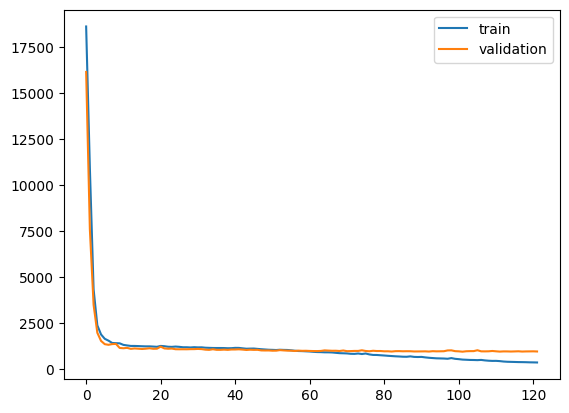

In [5]:
models_nocov = models[-1:]
X_train_nocov = X_train[-1:]
X_val_nocov = X_val[-1:]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_nocov = TrueSight(models_nocov, num_time_steps, filter_size = 256, context_size = 512, hidden_size = 1024, dropout_rate = 0.1)
ts_nocov.compile(optimizer=optimizer, loss='mse')

ts_nocov.fit(
    x = X_train_nocov, y = Y_train,
    validation_data = [X_val_nocov, Y_val],
    batch_size = 32,
    epochs = 1000,
    verbose = False,
    callbacks = callbacks,
)
ts_nocov.plot_training_history()
ts_nocov.save_weights('nocov.h5')

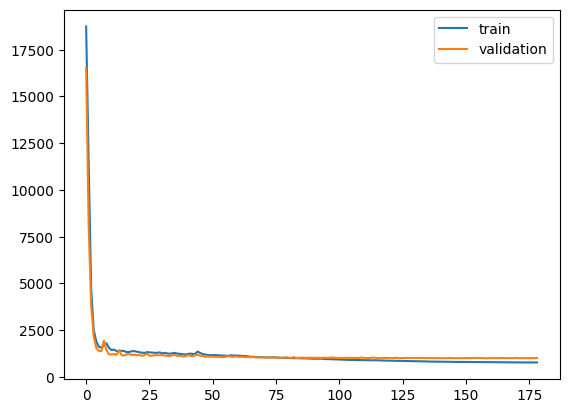

In [6]:
models_wcov = models.copy()
X_train_wcov = X_train.copy()
X_val_wcov = X_val.copy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
ts_wcov= TrueSight(models_wcov, num_time_steps, filter_size = 256, context_size = 512, hidden_size = 1024, dropout_rate = 0.1)
ts_wcov.compile(optimizer=optimizer, loss='mse')

ts_wcov.fit(
    x = X_train_wcov, y = Y_train,
    validation_data = [X_val_wcov, Y_val],
    batch_size = 32,
    epochs = 1000,
    verbose = False,
    callbacks = callbacks,
)
ts_wcov.plot_training_history()
ts_wcov.save_weights('ts_wcov.h5')

In [7]:
yhat_nocov = ts_nocov.predict(X_val_nocov, n_repeats = 100, n_quantiles = 15, verbose = False)
yhat_wcov = ts_wcov.predict(X_val_wcov, n_repeats = 100, n_quantiles = 15, verbose = False)

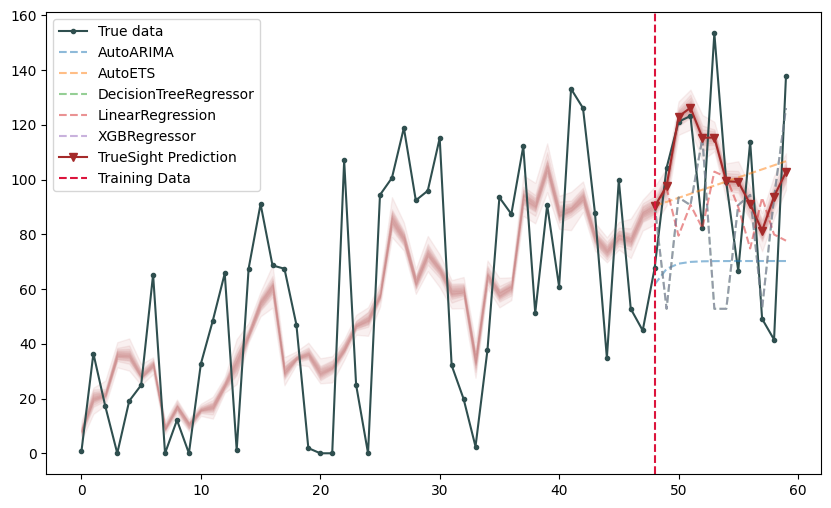

In [31]:
from matplotlib import pyplot as plt
idx = np.random.randint(0, len(yhat_nocov))
true = Y_val[idx]
pred_wcov = yhat_wcov[:,idx]
_, ax = plt.subplots(figsize=(10, 6), dpi=100)

ax.plot(true, ".-", color = "darkslategray", label = "True data")
for i in range(pred_wcov.shape[0] // 2):
    if (i == 0):
        ax.fill_between(np.arange(0, num_time_steps), pred_wcov[-i-1], pred_wcov[i], alpha = 0.5 / (pred_wcov.shape[0] / 2), color = "brown")
    else:
        ax.fill_between(np.arange(0, num_time_steps), pred_wcov[-i-1], pred_wcov[i], alpha = 0.5 / (pred_wcov.shape[0] / 2), color = "brown")

for model_id, model in enumerate(models[:-1]):
    ax.plot(np.arange(num_time_steps - forecast_horizon, num_time_steps), X_val[model_id][idx], "--", label = model, alpha = 0.5)
    
ax.plot(np.arange(num_time_steps - forecast_horizon, num_time_steps), pred_wcov.mean(axis=0)[-forecast_horizon:], "v-", label = "TrueSight Prediction", color = "brown")
ax.axvline(num_time_steps - forecast_horizon, linestyle = "--", color = 'crimson', label = 'Training Data')
plt.legend()
plt.show()

In [10]:
evaluator_wcov = Evaluator(X_val, Y_val, yhat_wcov, ids_val)
evaluator_wcov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape      1.132222
mape       0.968696
mse      994.187243
rmse      23.223899
mae       17.788008
dtype: float64

In [11]:
evaluator_nocov = Evaluator(X_val, Y_val, yhat_nocov, ids_val)
evaluator_nocov.evaluate_prediction(evaluators = [smape, mape, mse, rmse, mae], return_mean = True)

smape      1.116661
mape       0.999206
mse      956.757250
rmse      22.498106
mae       17.473107
dtype: float64

In [12]:
group_a = smape(Y_val, yhat_wcov.mean(axis=0))
group_b = smape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 2.99871205107439
P-Value: 0.003428754111763748


In [13]:
group_a = mape(Y_val, yhat_wcov.mean(axis=0))
group_b = mape(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: -0.6109803172036818
P-Value: 0.5426128872430822


In [14]:
group_a = mse(Y_val, yhat_wcov.mean(axis=0))
group_b = mse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 2.1449271041074196
P-Value: 0.0344054236987915


In [15]:
group_a = rmse(Y_val, yhat_wcov.mean(axis=0))
group_b = rmse(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 3.3881578363404894
P-Value: 0.0010110665084321626


In [16]:
group_a = mae(Y_val, yhat_wcov.mean(axis=0))
group_b = mae(Y_val, yhat_nocov.mean(axis=0))

t_statistic, p_value = stats.ttest_rel(group_a, group_b)

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

T-Statistic: 1.6254634490882274
P-Value: 0.10724321276666442
